In [1]:
import pandas as pd
import numpy as np
import os

from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from collections import Counter

from sklearn.model_selection import train_test_split, GridSearchCV
import xgboost
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

import warnings
warnings.filterwarnings('ignore')

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from preprocess_data import new_df, correlated_features
from imblearn.over_sampling import SMOTE
from collections import Counter

1. Average coeff between sleep and stress =  0.052
uncorrelated

2. Average coeff between sleepProblem and stress =  0.034
uncorrelated

3. Average coeff between amCondition and stress =  0.197
correlated

4. Average coeff between amEmotion and stress =  0.194
correlated

5. Average coeff between pmEmotion and stress =  0.337
correlated

6. Average coeff between pmFatigue and stress =  0.311
correlated

7. Average coeff between sleep_score and stress =  0.004
uncorrelated

['amCondition', 'amEmotion', 'pmEmotion', 'pmFatigue']
[0.1968, 0.1938, 0.3369, 0.3105]


In [4]:
user4_df = new_df[new_df["userId"]=="user04"]
print("user04: ", len(user4_df))

user12_df = new_df[new_df["userId"]=="user12"]
print("user12: ", len(user12_df))

user24_df = new_df[new_df["userId"]=="user24"]
print("user24 :" , len(user24_df))

user04:  28
user12:  29
user24 : 30


In [5]:
filtered_df = new_df[correlated_features]

user4_corr = user4_df[correlated_features]
user12_corr = user12_df[correlated_features]
user24_corr = user24_df[correlated_features]

In [6]:
# user04 original dataset
counter1 = Counter(user4_df.pmStress)
print('user04 dataset')
print('=========================')
for k,v in counter1.items():
 per = v / len(user4_df.pmStress) * 100
 print('Stress level=%d, n=%d (%.3f%%)' % (k, v, per))
print()

# user12 original dataset
counter2 = Counter(user12_df.pmStress)
print('user12 dataset')
print('=========================')
for k,v in counter2.items():
 per = v / len(user12_df.pmStress) * 100
 print('Stress level=%d, n=%d (%.3f%%)' % (k, v, per))
print()

# user24 original dataset
counter3 = Counter(user24_df.pmStress)
print('user24 dataset')
print('=========================')
for k,v in counter3.items():
 per = v / len(user24_df.pmStress) * 100
 print('Stress level=%d, n=%d (%.3f%%)' % (k, v, per))


user04 dataset
Stress level=2, n=18 (64.286%)
Stress level=3, n=6 (21.429%)
Stress level=1, n=4 (14.286%)

user12 dataset
Stress level=2, n=19 (65.517%)
Stress level=1, n=4 (13.793%)
Stress level=3, n=6 (20.690%)

user24 dataset
Stress level=2, n=22 (73.333%)
Stress level=3, n=3 (10.000%)
Stress level=1, n=5 (16.667%)


In [7]:
# 데이터 클래스 불균형 문제 해결 - SMOTE 기법
smote = SMOTE(k_neighbors=2, random_state=0)

# user1
oversampled_X1, oversampled_y1 = smote.fit_resample(user4_corr, user4_df["pmStress"])
oversampled_X1 = pd.DataFrame(oversampled_X1, columns = correlated_features)

#user2
oversampled_X2, oversampled_y2 = smote.fit_resample(user12_corr, user12_df["pmStress"])
oversampled_X2 = pd.DataFrame(oversampled_X2, columns = correlated_features)

#user3
oversampled_X3, oversampled_y3 = smote.fit_resample(user24_corr, user24_df["pmStress"])
oversampled_X3 = pd.DataFrame(oversampled_X3, columns = correlated_features)


In [8]:
# user04 oversampled dataset
counter1 = Counter(oversampled_y1)
print('user04 oversampled dataset')
print('=========================')
for k,v in counter1.items():
 per = v / len(oversampled_y1) * 100
 print('Stress level=%d, n=%d (%.3f%%)' % (k, v, per))
print()

# user12 oversampled dataset
counter2 = Counter(oversampled_y2)
print('user12 oversampled dataset')
print('=========================')
for k,v in counter2.items():
 per = v / len(oversampled_y2) * 100
 print('Stress level=%d, n=%d (%.3f%%)' % (k, v, per))
print()

# user24 oversampled dataset
counter3 = Counter(oversampled_y3)
print('user24 oversampled dataset')
print('=========================')
for k,v in counter3.items():
 per = v / len(oversampled_y3) * 100
 print('Stress level=%d, n=%d (%.3f%%)' % (k, v, per))


user04 oversampled dataset
Stress level=2, n=18 (33.333%)
Stress level=3, n=18 (33.333%)
Stress level=1, n=18 (33.333%)

user12 oversampled dataset
Stress level=2, n=19 (33.333%)
Stress level=1, n=19 (33.333%)
Stress level=3, n=19 (33.333%)

user24 oversampled dataset
Stress level=2, n=22 (33.333%)
Stress level=3, n=22 (33.333%)
Stress level=1, n=22 (33.333%)


In [9]:
# Evaluate model

def calculate_accuracy(model, x_test,y_test):
    y_pred = model.predict(x_test)
    predictions = [round(value) for value in y_pred]
    accuracy = accuracy_score(y_test, predictions)
    precision = precision_score(y_test, y_pred, average = 'weighted')
    recall = recall_score(y_test, y_pred, average = 'weighted')
    f1 = f1_score(y_test, y_pred, average = 'weighted')
    print('Accuracy: %.4f' %(accuracy))
    print('Precision: %.4f' %(precision))
    print('Recall: %.4f' %(recall))
    print('F1 score: %.4f' %(f1))

In [10]:
# Make training data and test data
le = LabelEncoder()
xtrain1, xtest1, ytrain1, ytest1 = train_test_split(oversampled_X1, oversampled_y1, test_size=0.2, stratify=oversampled_y1, random_state=0)
ytrain1 = le.fit_transform(ytrain1)
ytest1 = le.fit_transform(ytest1)

xtrain2, xtest2, ytrain2, ytest2 = train_test_split(oversampled_X2, oversampled_y2, test_size=0.2, stratify=oversampled_y2, random_state=0)
ytrain2 = le.fit_transform(ytrain2)
ytest2 = le.fit_transform(ytest2)

xtrain3, xtest3, ytrain3, ytest3 = train_test_split(oversampled_X3, oversampled_y3, test_size=0.2, stratify=oversampled_y3, random_state=0)
ytrain3 = le.fit_transform(ytrain3)
ytest3 = le.fit_transform(ytest3)

In [11]:
# XGBoost Training (user4)
model_xgboost1 = XGBClassifier(
    booster = 'gbtree',
    objective = 'multi:softmax',
    eval_metric='merror'
)

model_xgboost1.fit(xtrain1,ytrain1)

ypredict1 = model_xgboost1.predict(xtest1)


In [12]:
print("=================================================")
print("Evaluation of stress estimation model for user04")
print("=================================================")
calculate_accuracy(model_xgboost1,xtest1,ytest1)

Evaluation of stress estimation model for user04
Accuracy: 0.5455
Precision: 0.5545
Recall: 0.5455
F1 score: 0.5434


In [13]:
# XGBoost Training (user12)
model_xgboost2 = XGBClassifier(
    booster = 'gbtree',
    objective = 'multi:softmax',
    eval_metric='merror'
)

model_xgboost2.fit(xtrain2,ytrain2)

ypredict2 = model_xgboost2.predict(xtest2)

In [14]:
print("=================================================")
print("Evaluation of stress estimation model for user12")
print("=================================================")
calculate_accuracy(model_xgboost2,xtest2,ytest2)

Evaluation of stress estimation model for user12
Accuracy: 0.6667
Precision: 0.8333
Recall: 0.6667
F1 score: 0.6413


In [15]:
# XGBoost Training (user24)
model_xgboost3 = XGBClassifier(
    booster = 'gbtree',
    objective = 'multi:softmax',
    eval_metric='merror'
)

model_xgboost3.fit(xtrain3,ytrain3)

ypredict3 = model_xgboost3.predict(xtest3)

In [16]:
print("=================================================")
print("Evaluation of stress estimation model for user24")
print("=================================================")
calculate_accuracy(model_xgboost3,xtest3,ytest3)

Evaluation of stress estimation model for user24
Accuracy: 0.8571
Precision: 0.8833
Recall: 0.8571
F1 score: 0.8465


In [17]:
print("Test stress estimation model for user04 using user12 and user24's lifelog data")
print()

print("[Test in user12]")
calculate_accuracy(model_xgboost1,xtest2,ytest2)
print()

print("[Test in user24]")
calculate_accuracy(model_xgboost1,xtest3,ytest3)

Test stress estimation model for user04 using user12 and user24's lifelog data

[Test in user12]
Accuracy: 0.4167
Precision: 0.4286
Recall: 0.4167
F1 score: 0.4069

[Test in user24]
Accuracy: 0.5000
Precision: 0.3423
Recall: 0.5000
F1 score: 0.4046


In [18]:
print("Test stress estimation model for user12 using user04 and user24's lifelog data")
print()

print("[Test in user04]")
calculate_accuracy(model_xgboost2,xtest1,ytest1)
print()

print("[Test in user24]")
calculate_accuracy(model_xgboost2,xtest3,ytest3)

Test stress estimation model for user12 using user04 and user24's lifelog data

[Test in user04]
Accuracy: 0.1818
Precision: 0.0808
Recall: 0.1818
F1 score: 0.1119

[Test in user24]
Accuracy: 0.2857
Precision: 0.2165
Recall: 0.2857
F1 score: 0.2232


In [19]:
print("Test stress estimation model for user24 using user04 and user12's lifelog data")
print()

print("[Test in user04]")
calculate_accuracy(model_xgboost3,xtest1,ytest1)
print()

print("[Test in user12]")
calculate_accuracy(model_xgboost3,xtest2,ytest2)

Test stress estimation model for user24 using user04 and user12's lifelog data

[Test in user04]
Accuracy: 0.2727
Precision: 0.1091
Recall: 0.2727
F1 score: 0.1558

[Test in user12]
Accuracy: 0.5833
Precision: 0.4815
Recall: 0.5833
F1 score: 0.4908


## Stress Prediction Analysis

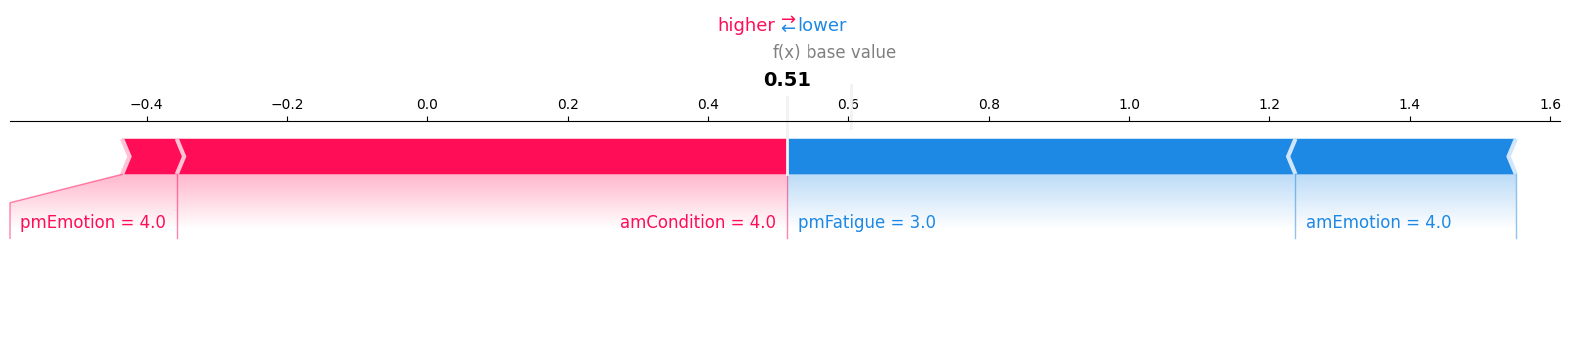

In [20]:
import shap

shap.initjs()
explainer1 = shap.TreeExplainer(model_xgboost1)
shap_values1 = explainer1.shap_values(xtrain1)
shap_values1 = shap_values1[1]

shap.force_plot(explainer1.expected_value[1], shap_values1[5], xtrain1.iloc[5], matplotlib=True)

In [30]:
print("Stress level: ", ytrain1[5]+1)
print()
print(xtrain1.iloc[5])

Stress level:  3

amCondition    4
amEmotion      4
pmEmotion      4
pmFatigue      3
Name: 51, dtype: int64


<Axes: title={'center': "Feature importance for user04's Stress Estimation"}, xlabel='F score', ylabel='Features'>

<Figure size 800x800 with 0 Axes>

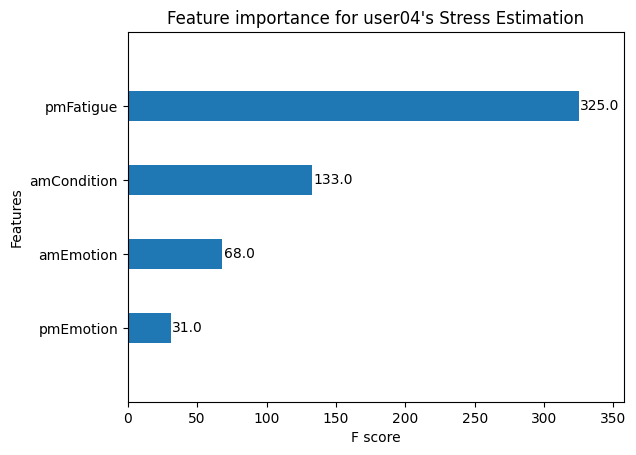

In [22]:
fig = plt.figure(figsize=(8,8))
xgboost.plot_importance(model_xgboost1, title= "Feature importance for user04's Stress Estimation", grid=False, height=0.4)

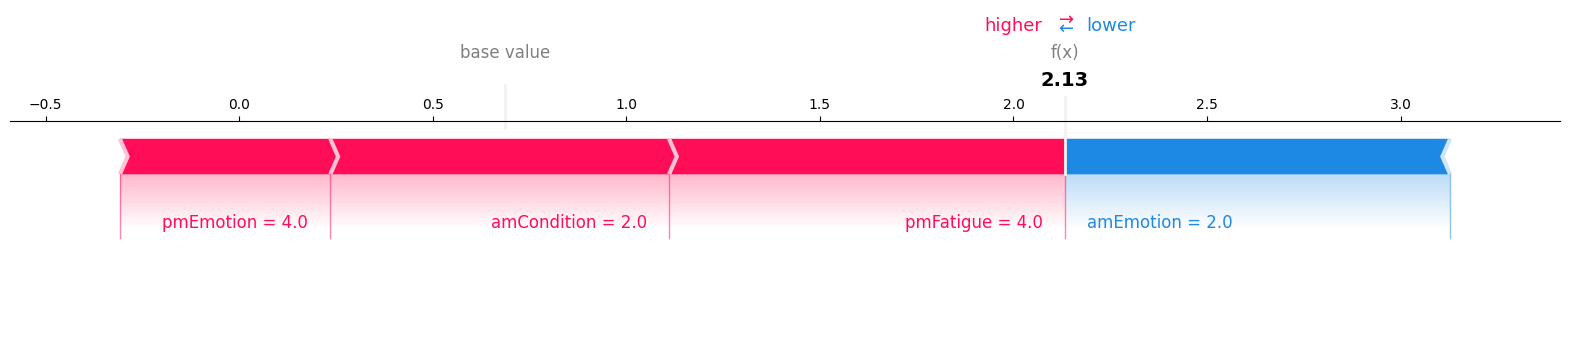

In [23]:
shap.initjs()
explainer2 = shap.TreeExplainer(model_xgboost2)
shap_values2 = explainer2.shap_values(xtrain2)
shap_values2 = shap_values2[1]

shap.force_plot(explainer2.expected_value[1], shap_values2[2], xtrain2.iloc[2], matplotlib=True)

In [29]:
print("Stress level: ", ytrain2[2]+1)
print()
print(xtrain2.iloc[2])

Stress level:  2

amCondition    2
amEmotion      2
pmEmotion      4
pmFatigue      4
Name: 4, dtype: int64


<Axes: title={'center': "Feature importance for user12's Stress Estimation"}, xlabel='F score', ylabel='Features'>

<Figure size 400x400 with 0 Axes>

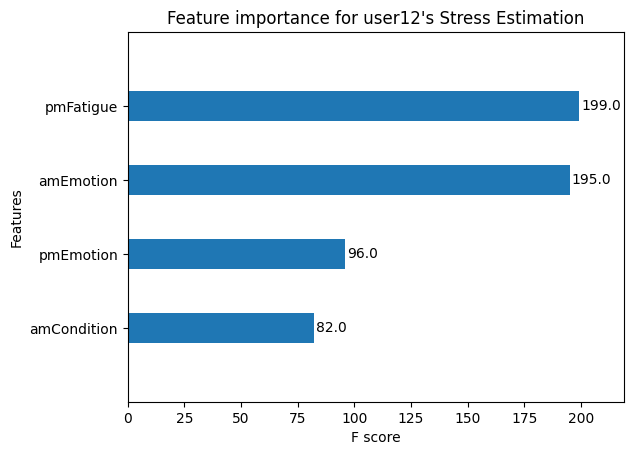

In [25]:
fig = plt.figure(figsize=(4,4))
xgboost.plot_importance(model_xgboost2, title= "Feature importance for user12's Stress Estimation", grid=False, height=0.4)

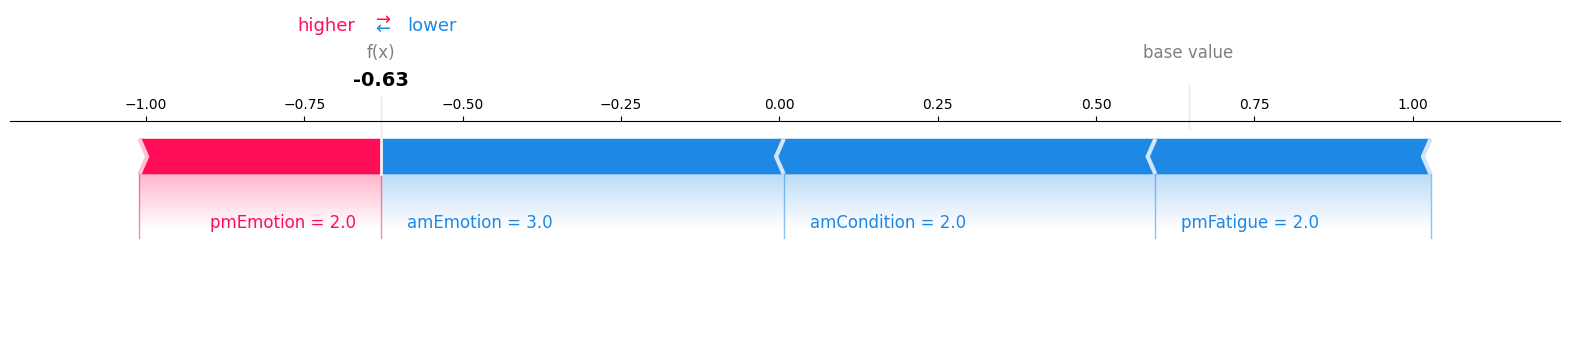

In [26]:
shap.initjs()
explainer3 = shap.TreeExplainer(model_xgboost3)
shap_values3 = explainer3.shap_values(xtrain3)
shap_values3 = shap_values3[1]

shap.force_plot(explainer3.expected_value[1], shap_values3[7], xtrain3.iloc[7], matplotlib=True)

In [27]:
print("Stress level: ", ytrain3[7]+1)
print()
print(xtrain3.iloc[7])

amCondition    2
amEmotion      3
pmEmotion      2
pmFatigue      2
Name: 31, dtype: int64
Stress level:  1


<Axes: title={'center': "Feature importance for user24's Stress Estimation"}, xlabel='F score', ylabel='Features'>

<Figure size 400x400 with 0 Axes>

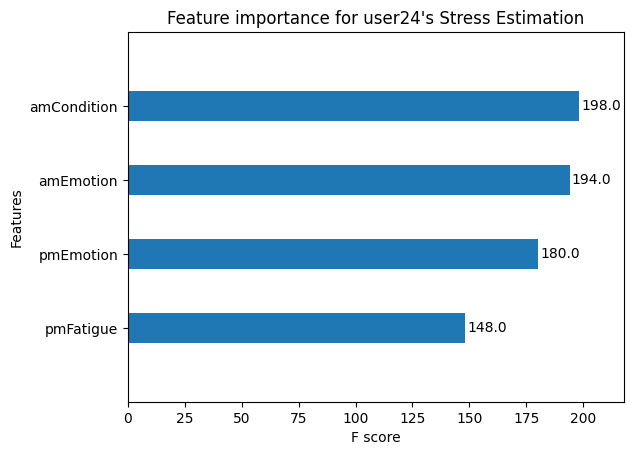

In [28]:
fig = plt.figure(figsize=(4,4))
xgboost.plot_importance(model_xgboost3, title= "Feature importance for user24's Stress Estimation", grid=False, height=0.4)